In [1]:
%pylab inline
from __future__ import division
import numpy as np
import pandas as pd
import skbio
import qiime_default_reference

Populating the interactive namespace from numpy and matplotlib


In [2]:
qiime_default_reference.get_reference_sequences()

unaligned_ref_fp = qiime_default_reference.get_reference_sequences()
aligned_ref_fp = qiime_default_reference.get_template_alignment()
tax_ref_fp = qiime_default_reference.get_reference_taxonomy()

Next, we'll define the forward and reverse primers as ``skbio.DNA`` objects. The primers that we're using here are pulled from [Supplementary File 1](http://www.nature.com/ismej/journal/v6/n8/extref/ismej20128x2.txt) of [Caporaso et al. 2012](http://www.nature.com/ismej/journal/v6/n8/full/ismej20128a.html). Note that we're reverse complementing the reverse primer when we load it here so that it's in the same orientation as our reference sequences.

In [3]:
fwd_primer = skbio.DNA("GTGCCAGCMGCCGCGGTAA", {'label':'fwd-primer'})
rev_primer = skbio.DNA("GGACTACHVGGGTWTCTAAT", {'label':'rev-primer'}).reverse_complement()

In [4]:
def seq_to_regex(seq):
    """ Convert a sequence to a regular expression
    """
    result = []
    for base in str(seq):
        if base in skbio.DNA.degenerate_chars:
            result.append('[{0}]'.format(
                ''.join(skbio.DNA.degenerate_map[base])))
        else:
            result.append(base)

    return ''.join(result)

In [5]:
regex = '({0}.*{1})'.format(seq_to_regex(fwd_primer),
                            seq_to_regex(rev_primer))

In [6]:
regex

'(GTGCCAGC[AC]GCCGCGGTAA.*ATTAGA[AT]ACCC[CTG][ATG]GTAGTCC)'

In [7]:
seq_count = 0
match_count = 0
for seq in skbio.io.read(unaligned_ref_fp, format='fasta', 
                         constructor=skbio.DNA):
    seq_count += 1
    for match in seq.find_with_regex(regex):
        match_count += 1

match_percentage = (match_count / seq_count) * 100
print('{0} of {1} ({2:.2f}%) sequences have exact matches to the regular expression.'.format(match_count, seq_count, match_percentage))

80108 of 99322 (80.65%) sequences have exact matches to the regular expression.


In [8]:
starts = []
stops = []
for seq in skbio.io.read(aligned_ref_fp, format='fasta', 
                         constructor=skbio.DNA):
    for match in seq.find_with_regex(regex, ignore=seq.gaps()):
        starts.append(match.start)
        stops.append(match.stop)

In [9]:
pd.Series(starts).describe()

count    3033.000000
mean     2227.020442
std         2.276611
min      2171.000000
25%      2227.000000
50%      2227.000000
75%      2227.000000
max      2339.000000
dtype: float64

In [10]:
pd.Series(stops).describe()

count    3033.000000
mean     4090.132212
std         7.317930
min      4089.000000
25%      4090.000000
50%      4090.000000
75%      4090.000000
max      4493.000000
dtype: float64

In [11]:
locus = slice(int(np.median(starts)), int(np.median(stops)))
locus

slice(2227, 4090, None)

In [12]:
subset_fraction = 1.0
kmer_counts = []
seq_ids = []

for seq in skbio.io.read(aligned_ref_fp, format='fasta',
                         constructor=skbio.DNA):
    if np.random.random() > subset_fraction: continue
    seq_ids.append(seq.metadata['id'])
    sliced_seq = seq[locus].degap()
    kmer_counts.append(sliced_seq.kmer_frequencies(8))

In [13]:
from sklearn.feature_extraction import DictVectorizer
X = DictVectorizer().fit_transform(kmer_counts)

In [14]:
taxonomy_level = 5
id_to_taxon = {}
with open(tax_ref_fp) as f:
    for line in f:
       id_, taxon = line.strip().split('\t')
       id_to_taxon[id_] = '; '.join(taxon.split('; ')[:taxonomy_level])

y = [id_to_taxon[seq_id] for seq_id in seq_ids]

In [15]:
from sklearn.feature_selection import SelectPercentile

X = SelectPercentile().fit_transform(X, y)

In [18]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Known taxonomy')
    plt.xlabel('Predicted taxonomy')
    plt.tight_layout()
    plt.show()

In [19]:
from sklearn.svm import SVC

y_pred = SVC(C=10, kernel='rbf', degree=3,
             gamma=0.001).fit(X_train, y_train).predict(X_test)

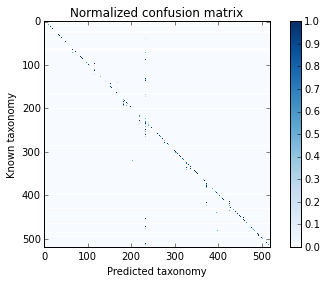

F-score: 0.443


In [21]:
from sklearn.metrics import confusion_matrix, f1_score

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

print("F-score: %1.3f" % f1_score(y_test, y_pred, average='micro'))

In [24]:
from sklearn.naive_bayes import MultinomialNB

y_pred = MultinomialNB().fit(X_train, y_train).predict(X_test)

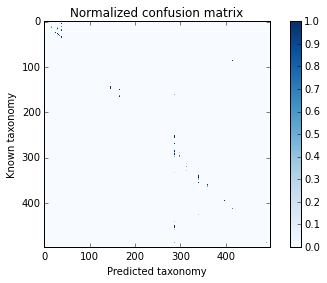

F-score: 0.186


In [25]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

print("F-score: %1.3f" % f1_score(y_test, y_pred, average='micro'))